## 8.7 Forecasting with ETS models
Point forecasts can be obtained from the models by iterating the equations for $t=T+1,\ldots,T+h$ and setting all $\epsilon_t=0$ for $t>T$.

For example, for model ETS(M,A,N), $y_{T+1}=(\ell_T+b_T)(1+\epsilon_{T+1})$. Therefore $\hat{y}_{T+1|T}=\ell_T+b_T$. Similarly, 
$$
\begin{align*}
y_{T+2} & =(\ell_{T+1}+b_{T+1})(1+\epsilon_{T+2})\\
 & =[(\ell_T+b_T)(1+\alpha\epsilon_{T+1})+b_T+\beta(\ell_T+b_T)\epsilon_{T+1}](1+\epsilon_{T+2}).
\end{align*}
$$
Therefore, $\hat{y}_{T+2|T} = \ell_T+2b_T$, and so on. These forecasts are identical to the forecasts from Holt’s linear method, and also to those from model ETS(A,A,N). Thus, the point forecasts obtained from the method and from the two models that underlie the method are identical (assuming that the same parameter values are used). ETS point forecasts constructed in this way are equal to the means of the forecast distributions, except for the models with multiplicative seasonality.

In [2]:
import sys
sys.path.append('..')
from utils import *

In [4]:
tourism = pd.read_csv("../data/tsibble/tourism.csv").pipe(
    compute, lambda x: dict(date=pd.to_datetime(x.Quarter.str.replace(" ", "")))
)


In [5]:
aus_holidays = (
    tourism.query("Purpose == 'Holiday'")
    .groupby("date".split())
    .Trips.sum()
    .reset_index()
    .set_index("date")
    .pipe(set_freq)
)


In [6]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [7]:
y = aus_holidays['Trips']
model = ETSModel(endog=y, error='mul', trend=None, seasonal='add').fit(disp=0)

In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Trips   No. Observations:                   80
Model:                       ETS(MNA)   Log Likelihood                -625.879
Date:                Thu, 21 Nov 2024   AIC                           1267.758
Time:                        14:51:03   BIC                           1286.814
Sample:                    01-01-1998   HQIC                          1275.398
                         - 10-01-2017   Scale                            0.004
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.1055      0.040      2.654      0.008       0.028       0.183
smoothing_seasonal     0.6200        nan        nan        nan         nan         nan
initial_level       9704.0286   3.67e+05      0.026      0.979    -7.1e+05     7.3e+05
initial_seasonal.0  1863.2007   3.67e+05      0.005      0.996   -7.18e+05    7.22e+05
initial_seasonal.1   311.8430   3.67e+05      0.001      0.999    -7.2e+05    7.21e+05
initial_seasonal.2  -175.2308   3.67e+05     -0.000      1.000    -7.2e+05     7.2e+05
initial_seasonal.3          0   3.67e+05          0      1.000    -7.2e+05     7.2e+05
===================================================================================
Ljung-Box (Q):                        6.28   Jarque-Bera (JB):                 8.73
Prob(Q):                              0.62   Prob(JB):                         0.01
Heteroskedasticity (H):               0.45   Skew:                            -0.15
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [34]:
def ciclean(ci_df):
    """Clean up conf_int() result column names."""
    ci_df = ci_df.copy()
    ci_df.columns = "lower", "upper"
    return ci_df


### Prediction intervals
A big advantage of the statistical models is that prediction intervals can also be generated — something that cannot be done using the point forecasting methods alone. The prediction intervals will differ between models with additive and multiplicative methods.

For most ETS models, a prediction interval can be written as
$$
\hat{y}_{T+h|T}\pm c\sigma_h
$$
where $c$ depends on the coverage probability, and $\sigma_h^2$ is the forecast variance.

In [40]:
forecasts = model.get_prediction(start=len(y), end=len(y)+ 8 - 1)
pred = forecasts.summary_frame(alpha=0.05)
conf_int_80 = ciclean(forecasts.pred_int(alpha=0.2))
conf_int_95 = ciclean(forecasts.pred_int(alpha=0.05))

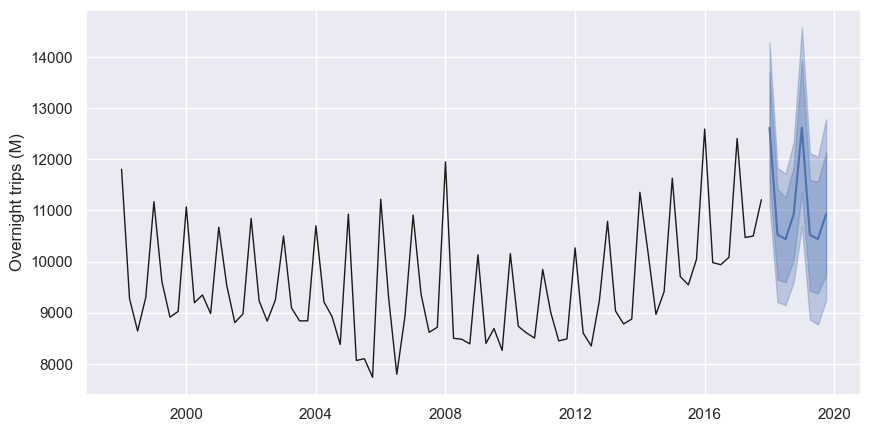

In [42]:
fix, ax = plt.subplots(figsize=(10, 5))
ax.plot(y, 'k', linewidth=1)
ax.plot(pred['mean'])
ax.fill_between(conf_int_95.index, conf_int_95.lower, conf_int_95.upper, alpha=.3, color='C0')
ax.fill_between(conf_int_80.index, conf_int_80.lower, conf_int_80.upper, alpha=0.3, color='C0')
ax.set(ylabel='Overnight trips (M)');